# Imports & Initialization

In [1]:
# Move to the root
import os
cwd = os.getcwd()
if os.path.basename(cwd) != "cv-in-farming":
    os.chdir("../")
print("Current directory:", os.getcwd())

Current directory: /home/cengerkin/Desktop/cv-in-farming


In [2]:
import torch
from torch.utils.data import DataLoader

from src.dataloader import FurrowDataset
from src.model import RidgeDetector
from src.solver import Solver, save_checkpoint, load_checkpoint

optimizers = {
    "adam": torch.optim.Adam,
    "sgd": torch.optim.SGD,
    #...
}

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Dataset

In [ ]:
# Specify input format for the network. 
# Allowed formats: darr, rgb, drgb, rgb-darr, rgb-drgb
input_format = "darr"

target_trans = ["to_tensor", "crop_right"]
input_trans = target_trans + ["normalize_imagenet"]

train_data_args = {
    "data_path": "dataset/20201112_140127",
    "input_trans": input_trans,
    "target_trans": target_trans,
    "input_format": input_format,
    "load_edge": True,
    "edge_width": 3,
    "load_time": False,
#     "start": 0,
#     "max_frames": 80,
#     "step": 10,
}

val_data_args = {
    "data_path": "dataset/20201112_140127",
    "input_trans": input_trans,
    "target_trans": target_trans,
    "input_format": input_format,
    "load_edge": True,
    "edge_width": 3,
    "load_time": False,
#     "start": 5,
#     "max_frames": 40,
#     "step": 10,
}

test_data_args = {
    "data_path": "dataset/20201112_140127",
    "input_trans": input_trans,
    "target_trans": target_trans,
    "input_format": input_format,
    "load_edge": True,
    "edge_width": 3,
    "load_time": False,
    "start": 1500,
    "end": np.inf,
    "max_frames": 8,
}

train_dataset = FurrowDataset(train_data_args)
# print(train_dataset)

val_dataset = FurrowDataset(val_data_args)
# print(val_dataset)

test_dataset = FurrowDataset(test_data_args)
# print(test_dataset)

# train_dataset.save_args("checkpoint/train_data_args")
# val_dataset.save_args("checkpoint/val_data_args")
# test_dataset.save_args("checkpoint/test_data_args")

# TODO: Change this later:
shuffled = np.random.permutation(train_dataset.frame_ids)
# 80-10-10
train, val, test = np.split(shuffled, [int(len(shuffled)*0.8), int(len(shuffled)*0.9)])
train_dataset.frame_ids = sorted(train)
val_dataset.frame_ids = sorted(val)
test_dataset.frame_ids = sorted(test)
print(train_dataset)
print(val_dataset)
print(test_dataset)

### Inspect Datasets

In [ ]:
train_id_set = set(train_dataset.frame_ids)
val_id_set = set(val_dataset.frame_ids)
test_id_set = set(test_dataset.frame_ids)
# print("Train:", train_dataset.frame_ids)
# print("Validation:", val_dataset.frame_ids)
# print("Test:", test_dataset.frame_ids)
print("Intersection:", list(train_id_set.intersection(val_id_set)))
print("Intersection:", list(train_id_set.intersection(test_id_set)))
print("Intersection:", list(val_id_set.intersection(test_id_set)))

In [ ]:
from utils.helpers import show_image, show_image_pairs, coord_to_mask
rand_idx = np.random.randint(0, 100)
item = train_dataset.__getitem__(rand_idx)
print(item)
frame_id = item["frame_id"]

print(f"Random Index: {rand_idx} <-> Frame ID: {frame_id}")

shape = (480, 640)
if train_data_args["load_darr"]:
    depth_arr = np.array(item['depth_arr'])
    print(f"Depth array shape: {depth_arr.shape}")

if train_data_args["load_edge"]:
    edge_mask = item['edge_mask']
    show_image(edge_mask.permute(1,2,0), cmap="gray")

if train_data_args["load_rgb"]:
    rgb_img = item['rgb_img']
    show_image(rgb_img.permute(1,2,0))

if train_data_args["load_drgb"]:
    depth_img = item['depth_img']
    show_image(depth_img.permute(1,2,0))

if train_data_args["load_time"]:
    time = np.array(item['time'])
    print(f"Timestamp: {time}")

## Model & Optimizer

### Create New Model & Optimizer Instance

In [ ]:
model_args = {
    "pretrained": True,
    "input_format": input_format
}

adam_args = {
    "lr": 0.001,
    "betas": (0.9, 0.999),
    "eps": 1e-08,
    "weight_decay": 0,
    "amsgrad": False,
}

sgd_args = {
     "lr": 0.1, 
    "momentum": 0.9
}

model = RidgeDetector(model_args)
optim = optimizers['adam'](filter(lambda p: p.requires_grad, model.parameters()), **adam_args)

print(model)
print(optim)

### Load Stored Model & Optimizer

In [3]:
epoch = 6
ckpt_path = f"checkpoint/{epoch}_ckpt.pth"
last_epoch, last_loss, last_acc, model, optim = load_checkpoint(ckpt_path)

### Load Original HED

In [ ]:
model_args = {
    "pretrained": False,
    "fuse": True,
}
weight_map = {
 'stage1.0.weight':'moduleVggOne.0.weight',
 'stage1.0.bias': 'moduleVggOne.0.bias',
 'stage1.2.weight': 'moduleVggOne.2.weight',
 'stage1.2.bias': 'moduleVggOne.2.bias',
 'sideout1.0.weight': 'moduleScoreOne.weight',
 'sideout1.0.bias': 'moduleScoreOne.bias',
 'stage2.5.weight':  'moduleVggTwo.1.weight',
 'stage2.5.bias':  'moduleVggTwo.1.bias',
 'stage2.7.weight':  'moduleVggTwo.3.weight',
 'stage2.7.bias':  'moduleVggTwo.3.bias',
 'sideout2.0.weight':  'moduleScoreTwo.weight',
 'sideout2.0.bias':  'moduleScoreTwo.bias',
 'stage3.10.weight':  'moduleVggThr.1.weight',
 'stage3.10.bias':  'moduleVggThr.1.bias',
 'stage3.12.weight':  'moduleVggThr.3.weight',
 'stage3.12.bias':  'moduleVggThr.3.bias',
 'stage3.14.weight':  'moduleVggThr.5.weight',
 'stage3.14.bias':  'moduleVggThr.5.bias',
 'sideout3.0.weight':  'moduleScoreThr.weight',
 'sideout3.0.bias':  'moduleScoreThr.bias',
 'stage4.17.weight':  'moduleVggFou.1.weight',
 'stage4.17.bias':  'moduleVggFou.1.bias',
 'stage4.19.weight':  'moduleVggFou.3.weight',
 'stage4.19.bias':  'moduleVggFou.3.bias',
 'stage4.21.weight':  'moduleVggFou.5.weight',
 'stage4.21.bias':  'moduleVggFou.5.bias',
 'sideout4.0.weight':  'moduleScoreFou.weight',
 'sideout4.0.bias':  'moduleScoreFou.bias',
 'stage5.24.weight':  'moduleVggFiv.1.weight',
 'stage5.24.bias':  'moduleVggFiv.1.bias',
 'stage5.26.weight':  'moduleVggFiv.3.weight',
 'stage5.26.bias':  'moduleVggFiv.3.bias',
 'stage5.28.weight':  'moduleVggFiv.5.weight',
 'stage5.28.bias':  'moduleVggFiv.5.bias',
 'sideout5.0.weight':  'moduleScoreFiv.weight',
 'sideout5.0.bias':  'moduleScoreFiv.bias',
 'fuse.weight': 'moduleCombine.0.weight',
 'fuse.bias': 'moduleCombine.0.bias',
}

ckpt_path = "checkpoint/network-bsds500.pytorch"
checkpoint = torch.load(ckpt_path)

model = RidgeDetector(model_args)

state = {}
for k1 in model.state_dict().keys():
    k2 = weight_map[k1]
    state[k1] = checkpoint[k2]
    
model.load_state_dict(state)

## Solver

In [ ]:
run_id = 0
old_runs = list(filter(lambda x: 'run' in x, os.listdir("log/")))
if old_runs:
    run_id = int(max(old_runs).split('run')[-1]) + 1
solver_args = {
    "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    "loss_func": "class_balanced_bce",
    "metric_func": "f1",
    "log_path": f"log/run{run_id}/",
}

solver = Solver(solver_args)

print(solver)

# Train

In [ ]:
batch_size = 20
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
print(f"Total train iterations (batch count): {len(train_loader)}")
print(f"Total validation iterations (batch count): {len(val_loader)}")

In [ ]:
# TODO: Separate args for val and train logging.
train_args = {
    "ckpt_path": "checkpoint",
    "max_epochs": 10,
    "ckpt_freq": 1,  # in epochs
    "val_freq": 1,   # in epochs
    "log_freq": 10,   # in iterations
    "vis_freq": 15,   # in iterations
    "max_vis": 5,    # Number of rows in tensorboard image log
    "input_format": input_format,
}
solver.train(model, optim, train_loader, val_loader, train_args)

In [ ]:
save_checkpoint(train_args['ckpt_path'], 1, model, optim, loss=None, acc=None)

# Test

## Batch Test

In [ ]:
test_args = {
    "input_format": "darr",
}

batch_size = 8
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
print(f"Total test iterations (batch count): {len(test_loader)}")

In [ ]:
results = solver.test(model, test_loader, test_args)

## Unit Test

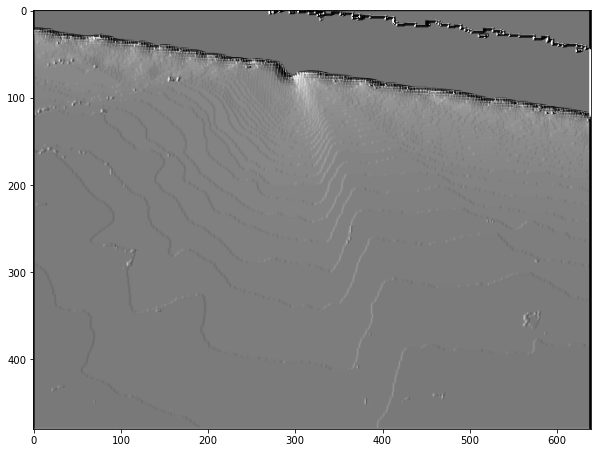

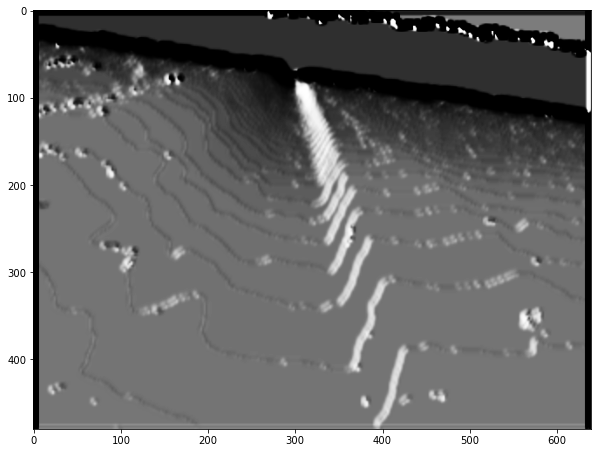

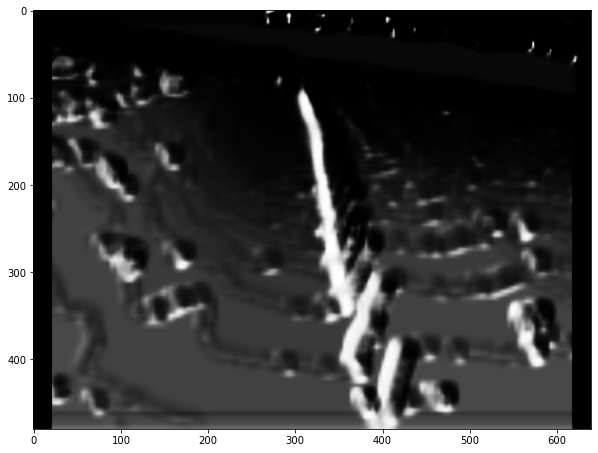

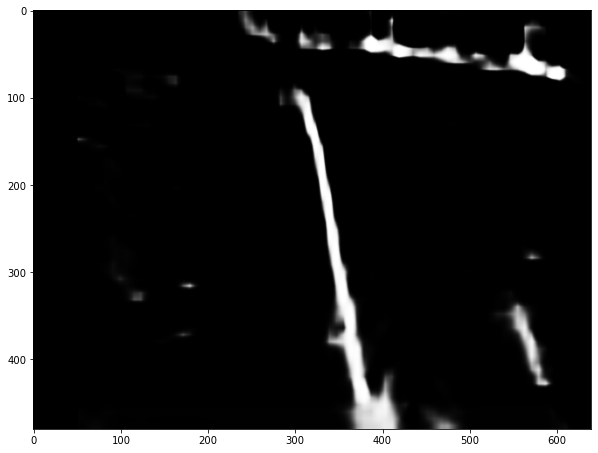

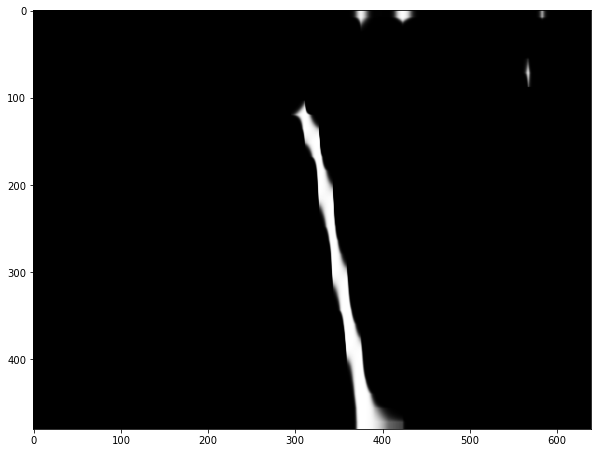

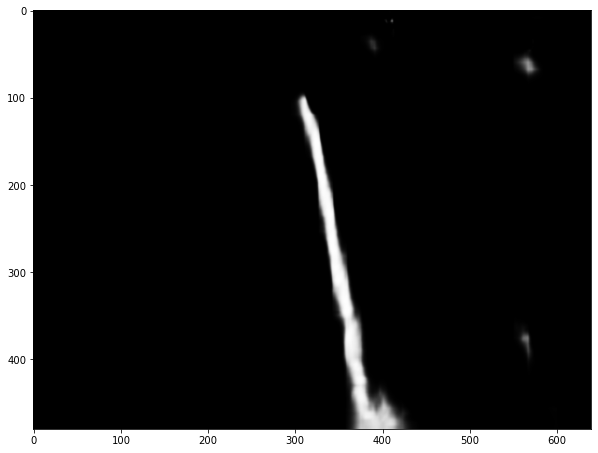

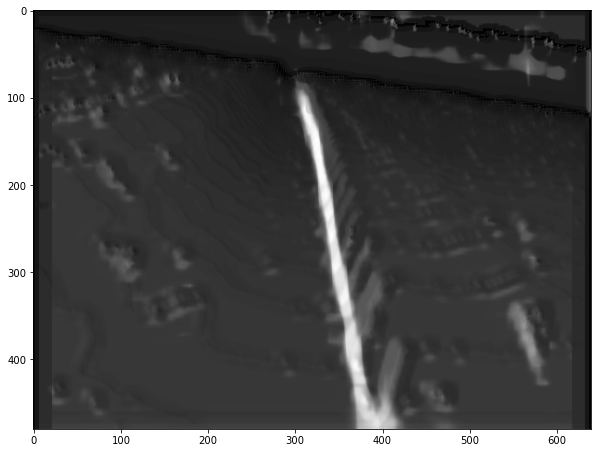

In [10]:
from PIL import Image
from torchvision.transforms import functional as F
from utils.helpers import show_image

# TODO: Refactor here
def detect(model, image):
    model.eval()
    X = F.to_tensor(image).unsqueeze(0)
    X = F.normalize(X, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    logits = model(X)
    logits = logits.squeeze(0)
    preds = torch.sigmoid(logits)
    pred0 = F.to_pil_image(preds[0])
    pred1 = F.to_pil_image(preds[1])
    pred2 = F.to_pil_image(preds[2])
    pred3 = F.to_pil_image(preds[3])
    pred4 = F.to_pil_image(preds[4])
    pred5 = F.to_pil_image(preds[5])
    pred6 = F.to_pil_image(preds.mean(dim=0, keepdims=True))
    return pred0, pred1, pred2, pred3, pred4, pred5, pred6

path = './dataset/20201112_125754/5032_depth.npy'
depth_arr = np.load(path)
depth_arr = np.rint(255 * (depth_arr / depth_arr.max())).astype(np.uint8)
depth_arr = np.stack([depth_arr, depth_arr, depth_arr], axis=-1)
# image = Image.open(path)
detections = detect(model, depth_arr)
for detection in detections:
    show_image(detection, cmap="gray")

# Generate Video from Frames

In [ ]:
from matplotlib.animation import FFMpegWriter

plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg'

folder = "front(20201112_140127)"
fig = plt.figure()
cut = folder_frame_map[folder][150:450]

# Fixing random state for reproducibility
metadata = dict(title='Detection Demo')
writer = FFMpegWriter(fps=30, metadata=metadata)

fig = plt.figure()
imgh = plt.imshow(np.zeros((480, 640), dtype=np.uint8))
ph, = plt.plot([], [], color="cyan", linewidth=2)

with writer.saving(fig, "Detection Demo.mp4", 100):
    for rgb_im_file, depth_arr_file, depth_im_file in cut:
        frame_idx = rgb_im_file.split("_")[0]

        rgb_im_path = os.path.join(folder, rgb_im_file)
        rgb_img = cv2.imread(rgb_im_path, cv2.IMREAD_COLOR)
        edge_pixels = np.load(os.path.join(folder, f"{frame_idx}_edge_pts.npy"))
        
        imgh.set_data(rgb_img)
        ph.set_data(edge_pixels[:,1], edge_pixels[:,0])
        
        writer.grab_frame()